<a href="https://colab.research.google.com/github/juniorskg/foreign-direct-investment-determinants/blob/main/end_to_end_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
pip install summarytools

In [231]:
import pandas as pd
import sklearn.model_selection
from summarytools import dfSummary
import sklearn.compose
import sklearn.preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import  root_mean_squared_error, r2_score, mean_squared_error
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

creat a function to calculate SMAPE

In [232]:
def symmetric_mean_absolute_percentage_error(y, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y) / (np.abs(y_pred) + np.abs(y) + 1e-10))


# **Data collection and exploration**

In [233]:
df= pd.read_excel("END TO END.xlsx")
df.sort_values(by=['Country Name', 'Year'], inplace=True)
df

,Country Name,GDP (current US$),"Inflation, consumer prices (annual %)",Domestic credit to private sector by banks (% of GDP),People using at least basic drinking water services (% of population),Access to electricity (% of population),High-technology exports (current US$),Political Stability and Absence of Violence/Terrorism: Estimate,Control of Corruption: Estimate,"Labor force, total","Population, total",Surface area (sq. km),"Foreign direct investment, net inflows (BoP, current US$)",Year
4991,Afghanistan,3521418059.923445,..,..,27.441856,4.4,NaN,-2.438969,-1.271724,4590768,19542982,652860,..,2000
4774,Afghanistan,2813571753.872532,..,..,27.47358,9.3,NaN,..,..,4614951,19688632,652860,..,2001
4557,Afghanistan,3825701438.999633,..,..,29.674863,14.1,NaN,-2.035034,-1.251137,4920862,21000256,652860,..,2002
4340,Afghanistan,4520946818.545814,..,..,31.875589,19,NaN,-2.198372,-1.34418,5312226,22645130,652860,..,2003
4123,Afghanistan,5224896718.67782,..,..,34.094431,23.8,NaN,-2.295682,-1.350647,5538525,23553551,652860,..,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,Zimbabwe,21832234925.50214,255.304991,5.201928,63.094954,46.7,27782789,-0.943303,-1.290334,5912685,15354608,390760,249500000,2019
867,Zimbabwe,21509698406.111595,557.201817,5.36389,62.666456,52.7,8275259,-1.052743,-1.308788,6001349,15669666,390760,150360000,2020
650,Zimbabwe,28371238665.511635,98.546105,6.92634,62.252798,49,4788223,-0.954443,-1.277147,6182422,15993524,390760,250000000,2021
433,Zimbabwe,27366627153.095413,104.705171,8.677194,62.294255,50.1,7822102,-0.894974,-1.259969,6370612,16320537,390760,395100000,2022


In [234]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Country Name[object],1. Afghanistan2. Pakistan3. Nepal4. Netherlands5. New Caledonia6. New Zealand7. Nicaragua8. Niger9. Nigeria10. North Macedonia11. other,"24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)24 (0.5%)4,968 (95.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADfUlEQVR4nO3cwWoTUQCG0ZsSit1MCIE8TB6iD+tD5G1CyCxs6SYujCtNFaxfMJ6zEtzM4mMyXu7v4nw+Dyg83PoB+H+IjYzYyIiNjNjIiI2M2MiIjYzYyCzGGE9jjHE+n19u/CzcueVms3keY4zFYvFZcPxND9M0radpWo8xHm/9MNw332xkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmY5z/Px8ue3mz4Jd88GgczCf5lFxZuNjHUVGesqMo4+yIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLyQcS2cjMELGW82MgYvZAxeyDj6ICM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxrVwMgYvZHyzkfEzSsa6iox1FRnfbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryLgWTsa6iow3GxmDFzIGL2QcfZARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IeNaOBmDFzLebGQMXsgYvJBx9EFGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryNggkLGuIuPNRsa6iox1FRlHH2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyLgWTsbghYw3GxmDFzIGL2QcfZARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IeNaOBmDFzK+2cj4GSVjXUXGuoqMbzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWRcCydjXUXGm42MwQsZgxcyjj7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLZyMwQuZ7282V8L5KG/XfiWXm83m+bJBgD82z/Px2nhqOU3TerfbvaxWq9dbPBz343Q6fdrv9+vD4fA4xvgxtjHGWK1Wr9vt9kv+dNyjp2t/4ZyNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzHKMb1dDbv0g/Pt+1dFynufjfr9fj3euhsDvugyofjqeci2cj3b1WrjBCxn/QCAjNjJiIyM2MmIjIzYyYiMjNjJiI/MVlHUQJ0ddGaUAAAAASUVORK5CYII="">",0(0.0%)
2,GDP (current US$)[object],1. ..2. 3521418059.9234453. 366990417129.03964. 404649125252.159555. 493026682800.62956. 574183763411.50767. 520117180313.9068. 463971018239.28059. 414466676831.1596710. 295008835380.996611. other,"220 (4.2%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)4,979 (95.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD10lEQVR4nO3cQWpbVxiG4f8a4cYTCWHwEto9eBFZbBahRXQPQvgOYtcTdZBJaJW2kPQVVZ9n6DM5gxcOgvt5OZ/PA4W7a1+A/w+xkREbGbGRERsZsZERGxmxkREbmWVmHmbm/hvn7+fz+TW8Dzds8/j4+HG73e4vHa7relqW5ZPg+BE22+12//z8/Lrb7d6+Pnh5eflwOBz2x+PxfmbExnfbzMzsdru3p6enzxfOH+L7cMP8QCAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjKbmS/frv3x4NLf4Hts1nU9HQ6H/Vz4dm1d19PMvPfX4hbZIJBZ/MssKn4gkLlbluWXZVn8GOBfdzczP8/MT9e+CLfPM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuZuZn6dmd+ufRFunw0CGc8oGbGRMXghY/BCxjNKRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMwQsZzygZsZERGxnrKjLWVWQ8o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkfGMkhEbGYMXMgYvZDyjZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQ8YySERsZgxcyBi9kPKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRnPKBmxkbGuImNdRcYzSkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjMELGc8oGbGRMXghY/BCxjNKRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMwQsZzygZsZERGxnrKjLWVWQ8o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkfGMkhEbGYMXMgYvZDyjZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQ8YySWWbmYWbur30Rbsb7+Xx+vXSweXx8/Ljdbvf1jbhN67qelmX5dCm4zXa73T8/P7/udru3a1yO2/Hy8vLhcDjsj8fj/cz8ObaZmd1u9/b09PQ5vx236OFbB34gkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnMfPk05NoX4b/v7zrarOt6OhwO+/mLT0Pgn1rX9TQz75fOfBbOj/bNz8Ktq8j4gUBGbGTERkZsZMRGRmxkxEZGbGTERuZ3gF2eNKmwNeYAAAAASUVORK5CYII="">",0(0.0%)
3,"Inflation, consumer prices (annual %)[object]",1. ..2. 11.58107517482523. 2.967603660044564. -2.489792650708465. 2.89819376026276. 3.837868028405017. 4.226217919163938. 3.700973164258429. 6.9332921556516110. 18.873646209386211. other,"933 (17.9%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)4,266 (81.9%)","<img src = ""data

# **Data preprocessing**

converting all non numeric data such as "..." to "nan" in column that are suppose to containt only numeric values

In [235]:

df.loc[:, df.columns != 'Country Name'] = df.loc[:, df.columns != 'Country Name'].apply(pd.to_numeric, errors='coerce')


check the missing values

In [236]:
df.isnull().sum()

,0
Country Name,0
GDP (current US$),220
"Inflation, consumer prices (annual %)",933
Domestic credit to private sector by banks (% of GDP),1060
People using at least basic drinking water services (% of population),431
Access to electricity (% of population),288
High-technology exports (current US$),2709
Political Stability and Absence of Violence/Terrorism: Estimate,555
Control of Corruption: Estimate,589
"Labor force, total",723


drop High-technology exports (current US$)

In [237]:
df=df.drop("High-technology exports (current US$)",axis=1)


drop all countries with more than 6 nan in a column

In [238]:
a=df.groupby('Country Name').apply(lambda x: x.isna().sum().max())

names_to_drop = a[a > 10].index

df = df[~df['Country Name'].isin(names_to_drop)]


<ipython-input-238-eeebf6e40308>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a=df.groupby('Country Name').apply(lambda x: x.isna().sum().max())


# **Handle missing values**

the function handle missing data of each column by filling it with the the value of the previous year for the same country + the column average change for that country.



**GDP**

In [239]:

df.sort_values(by=['Country Name', 'Year'], inplace=True)
A= df[["Country Name","GDP (current US$)","Year"]].dropna().sort_values(by=['Country Name', 'Year'])

A['change'] = df.groupby('Country Name')["GDP (current US$)"].diff()
A=A.fillna(0)
average_change = A.groupby('Country Name')['change'].mean()
average_change = pd.DataFrame(average_change)
df = pd.merge(df, average_change, on='Country Name', how='left')
df['change'] = np.where(df["GDP (current US$)"].isna(), df['change'], 0)
df["GDP (current US$)"] = df.groupby('Country Name')["GDP (current US$)"].ffill()
df["GDP (current US$)"]= df["GDP (current US$)"]+df["change"]
df=df.drop("change",axis=1)


<ipython-input-239-85943dee66e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['Country Name', 'Year'], inplace=True)
<ipython-input-239-85943dee66e0>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A=A.fillna(0)


**INFLATION**

In [240]:
df.sort_values(by=['Country Name', 'Year'], inplace=True)
A= df[["Country Name","Inflation, consumer prices (annual %)","Year"]].dropna().sort_values(by=['Country Name', 'Year'])
A['change'] = df.groupby('Country Name')["Inflation, consumer prices (annual %)"].diff()
A=A.fillna(0)
average_change = A.groupby('Country Name')['change'].mean()
average_change = pd.DataFrame(average_change)
df = pd.merge(df, average_change, on='Country Name', how='left')
df['change'] = np.where(df["Inflation, consumer prices (annual %)"].isna(), df['change'], 0)
df["Inflation, consumer prices (annual %)"] = df.groupby('Country Name')["Inflation, consumer prices (annual %)"].ffill()
df["Inflation, consumer prices (annual %)"]= df["Inflation, consumer prices (annual %)"]+df["change"]
df=df.drop("change",axis=1)




<ipython-input-240-c1295b932c82>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A=A.fillna(0)


**CREDIT**

In [241]:
df.sort_values(by=['Country Name', 'Year'], inplace=True)
A= df[["Country Name","Domestic credit to private sector by banks (% of GDP)","Year"]].dropna().sort_values(by=['Country Name', 'Year'])
A['change'] = df.groupby('Country Name')["Domestic credit to private sector by banks (% of GDP)"].diff()
A=A.fillna(0)
average_change = A.groupby('Country Name')['change'].mean()
average_change = pd.DataFrame(average_change)
df = pd.merge(df, average_change, on='Country Name', how='left')
df['change'] = np.where(df["Domestic credit to private sector by banks (% of GDP)"].isna(), df['change'], 0)
df["Domestic credit to private sector by banks (% of GDP)"] = df.groupby('Country Name')["Domestic credit to private sector by banks (% of GDP)"].ffill()
df["Domestic credit to private sector by banks (% of GDP)"]= df["Domestic credit to private sector by banks (% of GDP)"]+df["change"]
df=df.drop("change",axis=1)



<ipython-input-241-682b33769c8a>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A=A.fillna(0)


**WATER**

In [242]:
df.sort_values(by=['Country Name', 'Year'], inplace=True)
A= df[["Country Name","People using at least basic drinking water services (% of population)","Year"]].dropna().sort_values(by=['Country Name', 'Year'])
A['change'] = df.groupby('Country Name')["People using at least basic drinking water services (% of population)"].diff()
A=A.fillna(0)
average_change = A.groupby('Country Name')['change'].mean()
average_change = pd.DataFrame(average_change)
df = pd.merge(df, average_change, on='Country Name', how='left')
df['change'] = np.where(df["People using at least basic drinking water services (% of population)"].isna(), df['change'], 0)
df["People using at least basic drinking water services (% of population)"] = df.groupby('Country Name')["People using at least basic drinking water services (% of population)"].ffill()
df["People using at least basic drinking water services (% of population)"]= df["People using at least basic drinking water services (% of population)"]+df["change"]
df=df.drop("change",axis=1)



<ipython-input-242-c32e31bdc154>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A=A.fillna(0)


**ELECTRICITY**

In [243]:
df.sort_values(by=['Country Name', 'Year'], inplace=True)
A= df[["Country Name","Access to electricity (% of population)","Year"]].dropna().sort_values(by=['Country Name', 'Year'])
A['change'] = df.groupby('Country Name')["Access to electricity (% of population)"].diff()
A=A.fillna(0)
average_change = A.groupby('Country Name')['change'].mean()
average_change = pd.DataFrame(average_change)
df = pd.merge(df, average_change, on='Country Name', how='left')
df['change'] = np.where(df["Access to electricity (% of population)"].isna(), df['change'], 0)
df["Access to electricity (% of population)"] = df.groupby('Country Name')["Access to electricity (% of population)"].ffill()
df["Access to electricity (% of population)"]= df["Access to electricity (% of population)"]+df["change"]
df=df.drop("change",axis=1)


<ipython-input-243-2ce5ccf667f8>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A=A.fillna(0)


**LABOR**

In [244]:
df.sort_values(by=['Country Name', 'Year'], inplace=True)
A= df[["Country Name","Labor force, total","Year"]].dropna().sort_values(by=['Country Name', 'Year'])
A['change'] = df.groupby('Country Name')["Labor force, total"].diff()
A=A.fillna(0)
average_change = A.groupby('Country Name')['change'].mean()
average_change = pd.DataFrame(average_change)
df = pd.merge(df, average_change, on='Country Name', how='left')
df['change'] = np.where(df["Labor force, total"].isna(), df['change'], 0)
df["Labor force, total"] = df.groupby('Country Name')["Labor force, total"].ffill()
df["Labor force, total"]= df["Labor force, total"]+df["change"]
df=df.drop("change",axis=1)



<ipython-input-244-801c3788a14e>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A=A.fillna(0)


drop all the unhandled null values

In [245]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3490 entries, 8 to 3911
Data columns (total 13 columns):
 #   Column                                                                 Non-Null Count  Dtype 
---  ------                                                                 --------------  ----- 
 0   Country Name                                                           3490 non-null   object
 1   GDP (current US$)                                                      3490 non-null   object
 2   Inflation, consumer prices (annual %)                                  3490 non-null   object
 3   Domestic credit to private sector by banks (% of GDP)                  3490 non-null   object
 4   People using at least basic drinking water services (% of population)  3490 non-null   object
 5   Access to electricity (% of population)                                3490 non-null   object
 6   Political Stability and Absence of Violence/Terrorism: Estimate        3490 non-null   object
 7   Co

change data type to float

In [246]:
df["GDP (current US$)"]=df["GDP (current US$)"].astype(float)
df["Inflation, consumer prices (annual %)"]=df["Inflation, consumer prices (annual %)"].astype(float)
df["Domestic credit to private sector by banks (% of GDP)"]=df["Domestic credit to private sector by banks (% of GDP)"].astype(float)
df["People using at least basic drinking water services (% of population)"]=df["People using at least basic drinking water services (% of population)"].astype(float)
df["Access to electricity (% of population)"]=df["Access to electricity (% of population)"].astype(float)
df["Political Stability and Absence of Violence/Terrorism: Estimate"]=df["Political Stability and Absence of Violence/Terrorism: Estimate"].astype(float)
df["Control of Corruption: Estimate"]=df["Control of Corruption: Estimate"].astype(float)
df["Labor force, total"]=df["Labor force, total"].astype(float)
df["Surface area (sq. km)"]=df["Surface area (sq. km)"].astype(float)
df["Foreign direct investment, net inflows (BoP, current US$)"]=df["Foreign direct investment, net inflows (BoP, current US$)"].astype(float)


# **Feature engeenering**

**FDII**

In [247]:
min_f =df['Foreign direct investment, net inflows (BoP, current US$)'].min()
max_f=df['Foreign direct investment, net inflows (BoP, current US$)'].max()
change=max_f-min_f
df["FDII"]= (df['Foreign direct investment, net inflows (BoP, current US$)']-min_f)/change
df=df.drop("Foreign direct investment, net inflows (BoP, current US$)",axis=1)


**liquidity**

In [248]:
df["liquidity"]=df['Domestic credit to private sector by banks (% of GDP)']*df['GDP (current US$)']
df=df.drop("Domestic credit to private sector by banks (% of GDP)",axis=1)

**infrastructure index**

In [249]:
# electricity index
min_e =df['Access to electricity (% of population)'].min()
max_e=df['Access to electricity (% of population)'].max()
change=max_e-min_e

Ei= (df['Access to electricity (% of population)']-min_e)/change

# water index
min_w =df['People using at least basic drinking water services (% of population)'].min()
max_w=df['People using at least basic drinking water services (% of population)'].max()
change=max_w-min_w

Wi= (df['People using at least basic drinking water services (% of population)']-min_w)/change

# infrastructure index
I=((1-Ei)**2+(1-Wi)**2)/2
X=I.apply(lambda x: np.sqrt(x)if x > 0 else 0)
df["infrastructure index"]=1-X

df=df.drop(["People using at least basic drinking water services (% of population)","Access to electricity (% of population)"],axis=1)


 **divide into train and test**

In [281]:
df.insert(1, 'FDII', df.pop('FDII'))

In [282]:
df_train=df[df["Year"]!=2023]
df_test=df[df["Year"]==2023]

check number of countries

In [278]:
len(set(df_train['Country Name']))

163

# **Correlation**

In [289]:
df_cor= df_train.drop(["Country Name"],axis=1)
correlation_matrix=df_cor.corr()
correlation_df= pd.DataFrame(correlation_matrix)
correlation_df=correlation_df.drop('FDII')


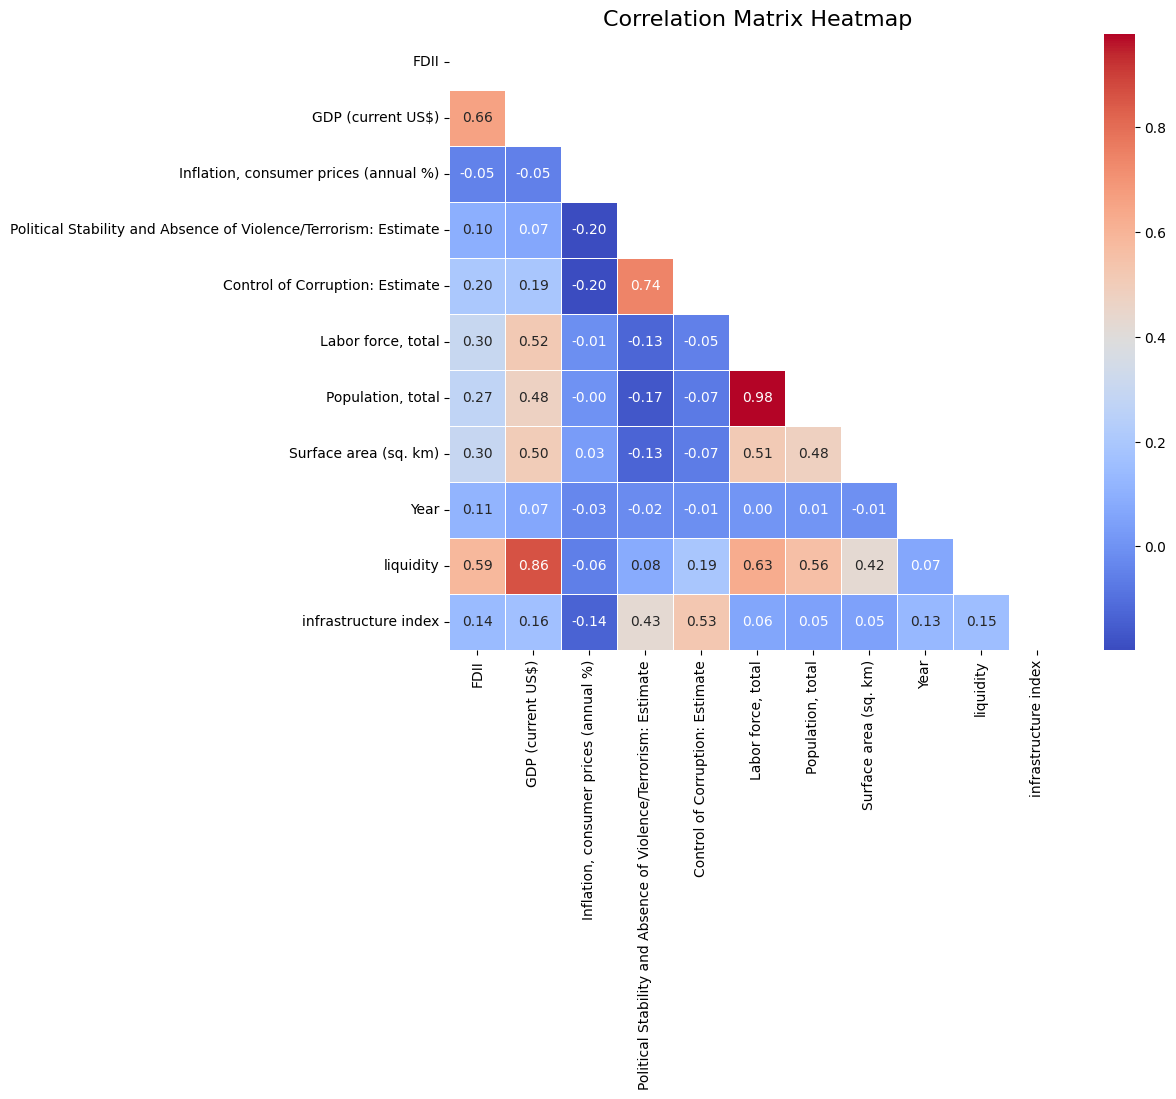

In [288]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True
)


plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

divide data into x and y

In [253]:
x_train=df_train.drop(["FDII",'Country Name'],axis=1)
y_train= df_train["FDII"]

x_test=df_test.drop(["FDII",'Country Name'],axis=1)
y_test= df_test["FDII"]

# XGB regressor


1.   It is good in capturing complex relationships in the data







In [254]:
xgb_mod= XGBRegressor(random_state=42)
xgb_mod.fit(x_train,y_train)
train_pred=xgb_mod.predict(x_train)
test_pred=xgb_mod.predict(x_test)

xgb_r2=r2_score(y_test, test_pred)
xgb_rmse=root_mean_squared_error(y_test, test_pred)
xgb_smape= symmetric_mean_absolute_percentage_error(y_test, test_pred)
print(f"the r2 score for XGB model is  {xgb_r2}")
print(f"the rmse score for XGB model is  {xgb_rmse}")
print(f"the smape score for XGB model is  {xgb_smape}")

the r2 score for XGB model is  0.18328470967589727
the rmse score for XGB model is  0.04548724593120064
the smape score for XGB model is  3.927099030023166


# Random Forest
reason for choosen it:


1.   it is powerfull and flexible
2.   resistant to noise and outliers
3.   it can manage high dimensional dataset



In [255]:
random_mod= RandomForestRegressor(random_state=42)
random_mod.fit(x_train,y_train)

test_pred=random_mod.predict(x_test)

random_mod_r2=r2_score(y_test, test_pred)
random_mod_rmse=root_mean_squared_error(y_test, test_pred)
random_mod_smape= symmetric_mean_absolute_percentage_error(y_test, test_pred)
print(f"the r2 score for random forest model is  {random_mod_r2}")
print(f"the rmse score for random forest model is  {random_mod_rmse}")
print(f"the smape score for random forest model is  {random_mod_smape}")

the r2 score for random forest model is  0.28572449789954213
the rmse score for random forest model is  0.04253899028895914
the smape score for random forest model is  3.241988941096759


# SMV

In [256]:
smv_mod=SVR()
smv_mod.fit(x_train,y_train)
train_pred=smv_mod.predict(x_train)
test_pred=smv_mod.predict(x_test)

smv_mod_r2=r2_score(y_test, test_pred)
smv_mod_rmse=root_mean_squared_error(y_test, test_pred)
smv_mod_smape= symmetric_mean_absolute_percentage_error(y_test, test_pred)
print(f"the r2 score for random forest model is  {smv_mod_r2}")
print(f"the rmse score for random forest model is  {smv_mod_rmse}")
print(f"the smape score for random forest model is  {smv_mod_smape}")

the r2 score for random forest model is  -0.1512940543201473
the rmse score for random forest model is  0.05400667380974568
the smape score for random forest model is  9.25018984623537


# linear regression

In [258]:
linear_mod= LinearRegression()
linear_mod.fit(x_train,y_train)
train_pred=linear_mod.predict(x_train)
test_pred=linear_mod.predict(x_test)

linear_mod_r2=r2_score(y_test, test_pred)
linear_mod_rmse=root_mean_squared_error(y_test, test_pred)
linear_mod_smape= symmetric_mean_absolute_percentage_error(y_test, test_pred)
print(f"the r2 score for linear regression model is  {linear_mod_r2}")
print(f"the rmse score for linear regrssion model is  {linear_mod_rmse}")
print(f"the smape score for linear regression model is  {linear_mod_smape}")

the r2 score for linear regression model is  0.04760432343955412
the rmse score for linear regrssion model is  0.04912052583365115
the smape score for linear regression model is  4.424489962933067


# ridge

In [259]:
ridge_mod= Ridge(random_state=42)
ridge_mod.fit(x_train,y_train)
train_pred=ridge_mod.predict(x_train)
test_pred=ridge_mod.predict(x_test)

ridge_mod_r2=r2_score(y_test, test_pred)
ridge_mod_rmse=root_mean_squared_error(y_test, test_pred)
ridge_mod_smape= symmetric_mean_absolute_percentage_error(y_test, test_pred)
print(f"the r2 score for ridge model is  {ridge_mod_r2}")
print(f"the rmse score for ridge model is  {ridge_mod_rmse}")
print(f"the smape score for ridge model is  {ridge_mod_smape}")

the r2 score for ridge model is  0.04761158048739289
the rmse score for ridge model is  0.049120338689434904
the smape score for ridge model is  4.424433148075931


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.53052e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# lasso

In [260]:
lasso_mod= Lasso(random_state=42)
lasso_mod.fit(x_train,y_train)
train_pred=lasso_mod.predict(x_train)
test_pred=lasso_mod.predict(x_test)

lasso_mod_r2=r2_score(y_test, test_pred)
lasso_mod_rmse=root_mean_squared_error(y_test, test_pred)
lasso_mod_smape= symmetric_mean_absolute_percentage_error(y_test, test_pred)
print(f"the r2 score for lasso model is  {lasso_mod_r2}")
print(f"the rmse score for lasso model is  {lasso_mod_rmse}")
print(f"the smape score for lasso model is  {lasso_mod_smape}")

the r2 score for lasso model is  0.07255151645449176
the rmse score for lasso model is  0.04847292167846574
the smape score for lasso model is  3.6885042655892035


# **Compare models**

In [261]:
models_evaluation= pd.DataFrame({
    'model':  ["xgb","random_forest","SMV","linear_regression","ridge","lasso"],
    'root_mean_squared_error': [xgb_rmse,random_mod_rmse,smv_mod_rmse,linear_mod_rmse,ridge_mod_rmse,lasso_mod_rmse],
    'r2': [xgb_r2,random_mod_r2,smv_mod_r2,linear_mod_r2,ridge_mod_r2,lasso_mod_r2],
    'Symmetric_Mean_Absolute_Percentage_Error ': [xgb_smape,random_mod_smape,smv_mod_smape,linear_mod_smape,ridge_mod_smape,lasso_mod_smape]

})
models_evaluation

,model,root_mean_squared_error,r2,Symmetric_Mean_Absolute_Percentage_Error
0,xgb,0.045487,0.183285,3.927099
1,random_forest,0.042539,0.285724,3.241989
2,SMV,0.054007,-0.151294,9.250190
3,linear_regression,0.049121,0.047604,4.424490
4,ridge,0.049120,0.047612,4.424433
5,lasso,0.048473,0.072552,3.688504


# **Compare features**

In [262]:
feature_importance_df = pd.DataFrame({
    'Feature':  x_train.columns ,
    "correlation": correlation_df['FDII'],
    'random forest model feature Importance': random_mod.feature_importances_,
    'Lasso model coefficient': lasso_mod.coef_

})

feature_importance_df

,Feature,correlation,random forest model feature Importance,Lasso model coefficient
GDP (current US$),GDP (current US$),0.660527,0.133648,1.523311e-14
"Inflation, consumer prices (annual %)","Inflation, consumer prices (annual %)",-0.049991,0.038413,-0.000000e+00
Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Te...,0.096039,0.044467,0.000000e+00
Control of Corruption: Estimate,Control of Corruption: Estimate,0.200773,0.064993,0.000000e+00
"Labor force, total","Labor force, total",0.299000,0.066533,-1.574128e-10
"Population, total","Population, total",0.274546,0.058851,5.056235e-11
Surface area (sq. km),Surface area (sq. km),0.296123,0.050671,-2.397383e-10
Year,Year,0.113801,0.051132,0.000000e+00
liquidity,liquidity,0.587088,0.467692,4.241946e-17
infrastructure index,infrastructure index,0.139331,0.023599,0.000000e+00


In [263]:
pd.DataFrame({
    "actual_values": y_test,
    "prediction": test_pred
})

,actual_values,prediction
47,0.414515,0.414661
71,0.414057,0.417842
95,0.410227,0.414848
119,0.413328,0.414711
143,0.450266,0.447176
...,...,...
3791,0.412160,0.415490
3815,0.412672,0.414379
3839,0.433907,0.419361
3863,0.412780,0.414710
